In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [3]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [4]:
# Detection function
def mediapipe_detection(image, model):
    # Converts BGR to RGB color
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Sets image to unwriteable status
    image.flags.writeable = False 

    # Makes detection
    results = model.process(image) 

    # Sets image back to writeable status
    image.flags.writeable = True 

    # Convert back to BGR
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 

    # Return image and results back to loop
    return image, results 

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1,circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1,circle_radius=1))

    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10), thickness=2,circle_radius=4),
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2,circle_radius=2))

    # Draw left-hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121,22,76), thickness=2,circle_radius=4),
                              mp_drawing.DrawingSpec(color=(121,44,250), thickness=2,circle_radius=2))

    # Draw right-hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66), thickness=2,circle_radius=4),
                              mp_drawing.DrawingSpec(color=(245,66,230), thickness=2,circle_radius=2))

In [139]:
# Function for opening the video feed
capture = cv2.VideoCapture(0) 

# Accesses mediapipe model
# Initial detection confidence & tracking confidence set
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # While camera is opened
    while capture.isOpened():
        # Reads feed
        ret, frame = capture.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks on live video
        draw_styled_landmarks(image, results)

        #Shows to screen
        cv2.imshow('Open Camera Feed', image)

        # Break when 'q' pressed
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    # Releases camera feed, closes all windows
    capture.release()
    cv2.destroyAllWindows()

In [22]:
# Function to extract keypoints, if none found creates array of zeros
def extract_keypoints(results):
    
    # Extracts pose keypoints into one array, if none found creates array of zeros to copy shape for error handling
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)

    # Extracts face keypoints, if none found creates array of zeros to copy shape for error handling
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    
    # Extracts left hand keypoints, if none found creates array of zeros to copy shape for error handling
    left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    
    # Extracts right hand landmarks, if none found creates array of zeros to copy shape for error handling
    right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    
    return np.concatenate([pose, face, left_hand, right_hand])

In [13]:
draw_styled_landmarks(frame, results)

In [14]:
result_test = extract_keypoints(results)

In [15]:
result_test

array([ 0.49109942,  0.2945241 , -0.53102612, ...,  0.11633141,
        0.41938344, -0.0385087 ])

In [16]:
np.save('0', result_test)

In [17]:
np.load('0.npy')

array([ 0.49109942,  0.2945241 , -0.53102612, ...,  0.11633141,
        0.41938344, -0.0385087 ])

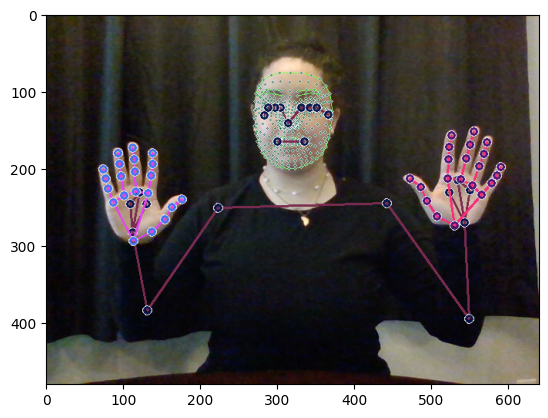

In [18]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [137]:
# Sets path for exported data (numpy arrays)
DATA_PATH = os.path.join('MP-ASL-gestures')

# Actions to detect (x actions multiplied by 30 frames multiplied by 30 sequences)
actions = np.array(['again', 'deaf', 'family', 'good', 'hard_of_hearing', 'hearing', 'inside', 'like', 'name', 'no', 'sorry', 'thank_you', 'what'])

# Number of videos
num_sequences = 30

# Number of frames
sequence_length = 30

In [138]:
# Loops through all actions and makes directories for them
for action in actions:
    # loop through videos
    for sequence in range(num_sequences):
        # Creates new folders and makes directories with subfolders, skips if folder already created
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [140]:
# Function for opening the video feed
capture = cv2.VideoCapture(0) 

# Accesses mediapipe model
# Initial detection confidence & tracking confidence set
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # Loop through actions
    for action in actions:

        #Loop though sequences
        for sequence in range(num_sequences):

            #Loop through video length
            for frame_num in range(sequence_length):
                
                # Reads feed
                ret, frame = capture.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks on live video
                draw_styled_landmarks(image, results)

                # Provides break for repositioning on first frame
                
                # If frame is first frame
                if frame_num == 0:
                    # Outprints to screen to show frames being collected
                    cv2.putText(image, 'COLLECTION STARTING', (120,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video number {}'.format(action, sequence), (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)

                    # Take 2 second break between each video
                    cv2.waitKey(2000)

                else:
                    # Prints out image currently collecting
                     cv2.putText(image, 'Collecting frames for {} Video number {}'.format(action, sequence), (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)

                # Exports keypoints
                keypoints = extract_keypoints(results)

                # Creates path
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))

                # Saves keypoints 
                np.save(npy_path, keypoints)
                
                #Shows to screen
                cv2.imshow('Open Camera Feed', image)

                # Break when 'q' pressed
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

    # Releases camera feed, closes all windows
    capture.release()
    cv2.destroyAllWindows()

In [142]:
# Allows training into partitions for training and testing
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [143]:
# Creates a dictionary of labels
label_map = {label:num for num, label in enumerate(actions)}

In [144]:
label_map

{'again': 0,
 'deaf': 1,
 'family': 2,
 'good': 3,
 'hard_of_hearing': 4,
 'hearing': 5,
 'inside': 6,
 'like': 7,
 'name': 8,
 'no': 9,
 'sorry': 10,
 'thank_you': 11,
 'what': 12}

In [145]:
# Array of sequences (features) used to train model to represent relationship between labels
sequences, labels = [], []

# loops through each action
for action in actions:

    # Loops through each sequence
    for sequence_index in range(num_sequences):

        # Blank array to represent all frames for particular sequence
        window = []

        # Loops through each frame
        for frame_num in range(sequence_length):

            # Loads frame
            res = np.load(os.path.join(DATA_PATH, action, str(sequence_index), "{}.npy".format(frame_num)))

            # Add frames to window
            window.append(res)

        # Append video to sequences
        sequences.append(window)

        # Append lables
        labels.append(label_map[action])

In [146]:
np.array(sequences).shape

(390, 30, 1662)

In [147]:
np.array(labels).shape

(390,)

In [148]:
# Stores sequences in array to make it easier to work with, uses x for x / y values
x = np.array(sequences)

In [149]:
x.shape

(390, 30, 1662)

In [150]:
# Converts labels to one encoded for y values
y = to_categorical(labels).astype(int) 

In [151]:
# Unpack results of train_test_split function with 5% of data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

In [152]:
# Imports dependancies for training model

# Allows building of sequential neural network
from tensorflow.keras.models import Sequential

# Imports LSTM layer, provides temporal component, allows action detection
from tensorflow.keras.layers import LSTM, Dense

# Imports TensorBoard for logging and tracing during training
from tensorflow.keras.callbacks import TensorBoard

# Imports optimizer
from tensorflow.keras.optimizers import Adam

In [153]:
# Create log directory
log_dir = os.path.join('Log-dir')

# Set up TensorBoard callback
tb_callback = TensorBoard(log_dir=log_dir)

In [154]:
# Instantiates model
model = Sequential()

# Adds three sets of LSTM layers
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))

# Adds dense fully connected layers for fully connected neural network
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

C:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [155]:
# Set up model for training and metrics for tracking
optimizer = Adam(learning_rate=0.0001)  # Set a lower learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [156]:
# Train model
model.fit(x_train, y_train, epochs=500, callbacks=[tb_callback])

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - categorical_accuracy: 0.0726 - loss: 2.5717
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.1111 - loss: 2.5447
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.2356 - loss: 2.5010
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.2104 - loss: 2.4465
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.1986 - loss: 2.3851
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.2316 - loss: 2.3221
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_accuracy: 0.1826 - loss: 2.3418
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.2231 - loss: 2.2937
Epoch 9/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.1594 - loss: 2.2393
Epoch 10/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_accuracy: 0.1854 - loss: 2.2216
Epoch 11/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0

KeyboardInterrupt: 

In [157]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 64)              │         442,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 13)                  │             429 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,791,017 (6.83 MB)

 Trainable params: 597,005 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,194,012 (4.55 MB)

In [158]:
results = model.predict(x_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


In [165]:
actions[np.argmax(results[3])]

'inside'

In [166]:
actions[np.argmax(y_test[3])]

'inside'

In [167]:
# Save model
model.save('action6.keras')

In [168]:
# Import confusion matrix to evaluate true and false positives and negatives
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [169]:
# Make more predictions for testing accuracy
yhat = model.predict(x_train)

# Extract predicted classes converted to categorical label
ytrue = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [170]:
# Returns confusion matrix of shape (2,2)
multilabel_confusion_matrix(ytrue, yhat)

array([[[175,   0],
        [  0,  20]],

       [[181,   0],
        [  0,  14]],

       [[182,   0],
        [  0,  13]],

       [[181,   0],
        [  0,  14]],

       [[185,   0],
        [  0,  10]],

       [[173,   0],
        [  0,  22]],

       [[183,   0],
        [  0,  12]],

       [[181,   0],
        [  0,  14]],

       [[179,   0],
        [  0,  16]],

       [[184,   0],
        [  0,  11]],

       [[178,   0],
        [  0,  17]],

       [[177,   0],
        [  0,  18]],

       [[181,   0],
        [  0,  14]]], dtype=int64)

In [171]:
accuracy_score(ytrue, yhat)

1.0

In [ ]:
# Video feed for testing

# Appending to list collects 30 frames to generate prediction
sequence = []

# Allows concatenation of history 
sentence = []

predictions = []

# Only renders results if above a certain threshold
threshold = 0.4

# Function for opening the video feed
capture = cv2.VideoCapture(0) 

# Accesses mediapipe model
# Initial detection confidence & tracking confidence set
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # While the camera is opened
    while capture.isOpened():
        # Reads feed
        ret, frame = capture.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks on live video
        draw_styled_landmarks(image, results)

        # Extract keypoints from video
        keypoints = extract_keypoints(results)

        # Appending keypoints to sequence list
        sequence.append(keypoints)

        # Grabs the last 30 frames to generate a prediction
        sequence = sequence[-30:]

        # Run prediction only if the length of sequence equals 30
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predicted_action_index = np.argmax(res)
            predicted_action = actions[predicted_action_index]
            print(predicted_action)
            predictions.append(predicted_action)

            # Visualization logic
            # If result above threshold
            if res[predicted_action_index] > threshold:
                sentence.append(predicted_action)

        # If the sentence length is greater than 5
        if len(sentence) > 5:
            # Grab the last five values
            sentence = sentence[-5:]
            
            # Get the latest predicted action
            latest_predicted_action = sentence[-1]
            
            # Display the latest predicted action
            cv2.putText(image, latest_predicted_action, (3,30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)

        # Shows to screen
        cv2.imshow('Open Camera Feed', image)

        # Break when 'q' pressed
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

# Releases the camera feed, closes all windows
capture.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
inside
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
inside
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
inside
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
inside
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
inside
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
inside
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
inside
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
inside
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
inside
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
good
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
good
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
good
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
good
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
like
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
like
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
like
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
like
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
again
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
again
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
again
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
again
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
again
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

In [136]:
import tensorflow as tf

# Clear the TensorFlow session and reset the global TensorFlow graph state
tf.compat.v1.reset_default_graph()
tf.keras.backend.clear_session()

In [87]:
capture.release()
cv2.destroyAllWindows()